# Imports

In [1]:
import random
random.seed(24071992)
import numpy as np
np.random.seed(24071992)
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial
import pandas as pd
import pickle
from astropy.stats import RipleysKEstimator
from collections import Counter
import itertools
import networkx as nx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook

In [9]:
s = 0

#for i in [66,68,69,93,78,85,47,73,87]:#,55,54,45,21,13,90,91,79]:
for i in [55,54,45,21,13,90,91,79]:
    s += Counter(labels_a)[i]
    
print(s,
      len(labels_a),
      (s/4700)*100
     )

1952 4700 41.53191489361702


# Basic function (test data)

<IPython.core.display.Javascript object>


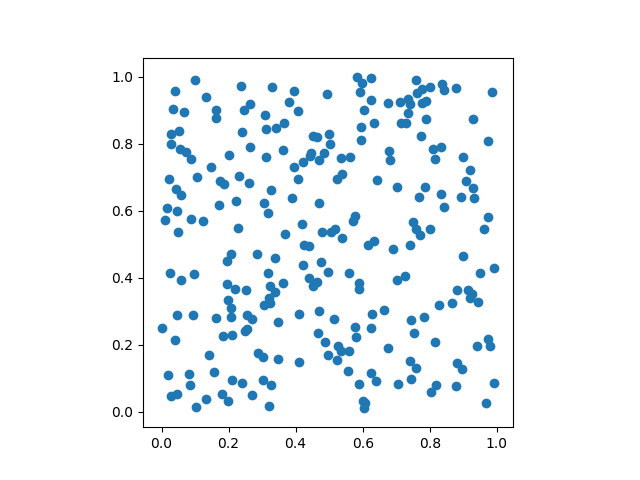

In [30]:
cells = np.random.rand(250,2)
plt.figure()
plt.scatter(cells[:,0], cells[:,1])
plt.gca().set_aspect('equal')

In [31]:
#Generate labels
labels = np.zeros((1,len(cells)), dtype='int64')
for i, c in enumerate(cells):
    labels[0,i] = int(random.random() + c[0])
labels = labels[0]

<IPython.core.display.Javascript object>


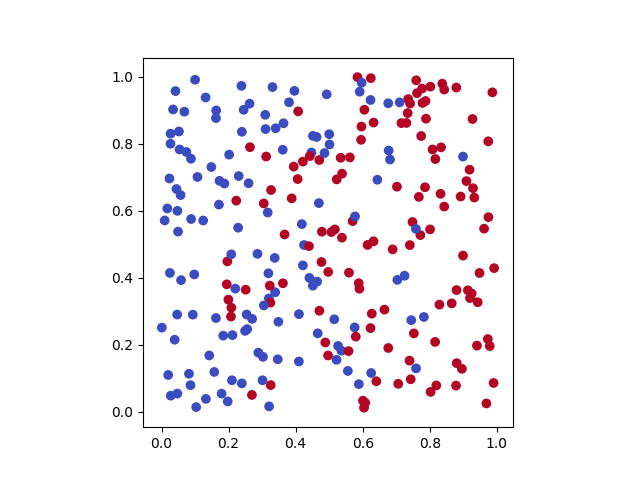

In [32]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels, cmap=matplotlib.cm.coolwarm)
plt.gca().set_aspect('equal')

In [43]:
x = scipy.spatial.KDTree(cells, leafsize=10)

<IPython.core.display.Javascript object>


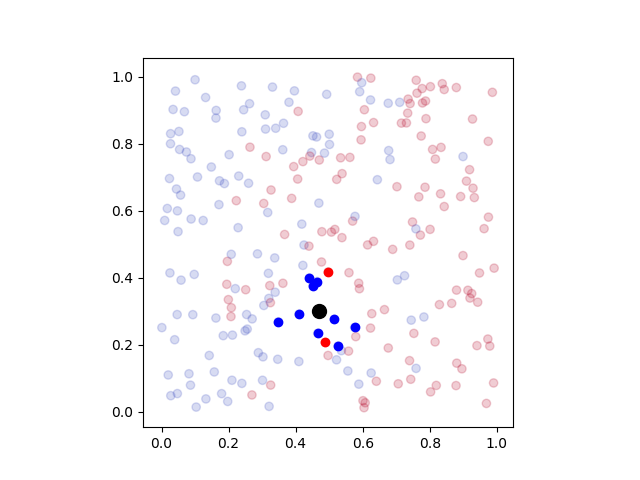

In [56]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels, cmap=matplotlib.cm.coolwarm, alpha=0.2)
cell = 21
neighbours = x.query(cells[cell], k=12)[1]
for c in neighbours:
    if labels[c] == 0:
        plt.scatter(cells[c, 0], cells[c, 1], c='blue')
    if labels[c] == 1:
        plt.scatter(cells[c, 0], cells[c, 1], c='red')
plt.scatter(cells[cell, 0], cells[cell, 1], c='black', s=100)
plt.gca().set_aspect('equal')

In [33]:
x = scipy.spatial.KDTree(cells, leafsize=10)

In [34]:
labels_1 = np.zeros_like(labels)
for i, c in enumerate(cells):
    neighbours = x.query(cells[i], k=12)[1]
    most_common_label = np.argmax(np.bincount(labels[neighbours]))
    labels_1[i] = most_common_label
    

<IPython.core.display.Javascript object>


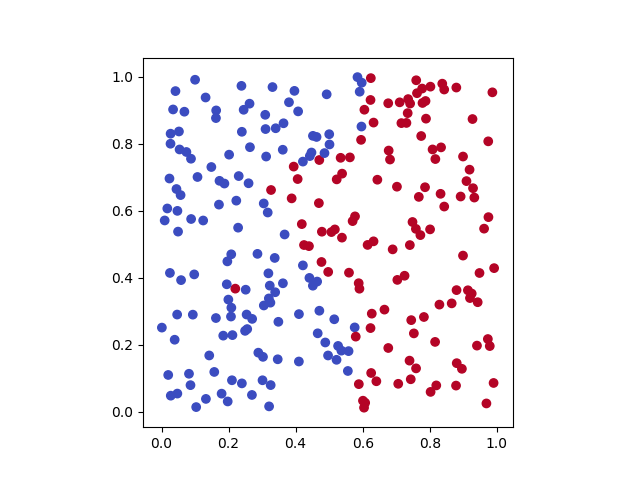

In [35]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels_1, cmap=matplotlib.cm.coolwarm)
plt.gca().set_aspect('equal')

In [36]:
labels_2 = np.zeros_like(labels)
for i, c in enumerate(cells):
    neighbours = x.query(cells[i], k=12)[1]
    most_common_label = np.argmax(np.bincount(labels_1[neighbours]))
    labels_2[i] = most_common_label

<IPython.core.display.Javascript object>


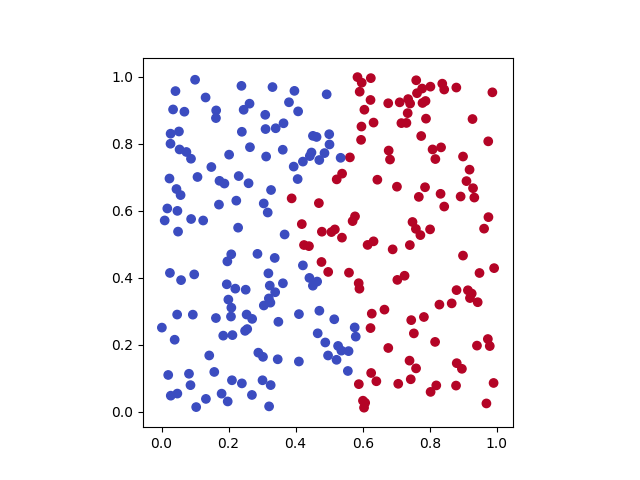

In [37]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels_2, cmap=matplotlib.cm.coolwarm)
plt.gca().set_aspect('equal')

# Cortex regionalization

## Data import

In [3]:
df_fish_totmol_clean = pickle.load(open("df_fish_totmol_clean_180220.p", 'rb'))
df_coord = pickle.load(open("Cell_coordinates.p", 'rb'))
df_coord = df_coord.loc[:,df_fish_totmol_clean.columns]
labels_a = pickle.load(open("labels_a_df_fish_totmol_clean_180220.p", 'rb'))
cell_labels = dict(zip(df_fish_totmol_clean.columns, labels_a))

In [6]:
x_min = df_coord.loc['X'].min()
x_max = df_coord.loc['X'].max()
y_min = df_coord.loc['Y'].min()
y_max = df_coord.loc['Y'].max()
area = ((x_max-x_min)*(y_max-y_min))
Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
radii = np.linspace(1000,20000, 100)

In [7]:
RK_500 = []
RK_750 = []
RK_1000 = []
RK_3000 = []
RK_7000 = []
RK_10000 = []
for i in np.sort(np.unique(labels_a)):
    filt = labels_a == i
    estimate =  Kest(data=np.array(df_coord.loc[:,filt].T), radii=radii, mode='none')
    RK_500.append(estimate[np.argmin(np.abs(radii - 500))]) 
    RK_750.append(estimate[np.argmin(np.abs(radii - 750))]) 
    RK_1000.append(estimate[np.argmin(np.abs(radii - 1000))]) 
    RK_3000.append(estimate[np.argmin(np.abs(radii - 3000))]) 
    RK_7000.append(estimate[np.argmin(np.abs(radii - 7000))]) 
    RK_10000.append(estimate[np.argmin(np.abs(radii - 10000))]) 
    
    #Get the estimate of the radii closest to 3000 and append list

In [8]:
def plot_cell_pos(coordinate_df, cell_ids=None, cell_of_interest=None, color='gray', color_highlight1='r', color_highlight2='r', s=5, standalone = True, mode='Highlight'):
    """
    Plot the centroids of all cells in grey. A selection of cells can be made red.
    And one cell of interest can be shown larger with a white border around.
    Input:
    `coordinate_df`(pd df): Pandas df with cells in columns, and 'X' & 'Y' as rows.
    `cell_ids`(list): If selection of cells to plot, enter a list of cell ids. Default = None
    `color`(str): color of cells, default gray
    `s`(float): Size of dots. Default = 5
    `stanalone`(bool): If true it creates a figure. If false it can be used as subplot
    `mode`(str): if 'highlight' it is possible to highlight a group of cells and/or one cell
    `color_highlight1`: color of group of cells. default='r' 
    `color_highlight2`: color of single cells. default='r'
    
    """
    if standalone == True:
        plt.figure(figsize=(7,7))
        
    if mode.lower() == 'tsne':
        plt.scatter(coordinate_df.loc['X',:], coordinate_df.loc['Y',:], linewidths=0, c=color, s=s)
    
    if mode.lower() == 'highlight':
        plt.scatter(coordinate_df.loc['X',:], coordinate_df.loc['Y',:], linewidths=0, c=color, s=s)
        if cell_ids != None:
            plt.scatter(coordinate_df.loc[:,cell_ids].loc['X'], coordinate_df.loc[:,cell_ids].loc['Y'], color=color_highlight1, s=s*2)
        if cell_of_interest != None:
            plt.scatter(coordinate_df.loc[:,cell_of_interest][0], coordinate_df.loc[:,cell_of_interest][1], color=color_highlight2, s=s*8, lw=2, edgecolor='w')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.gca().axis('equal')
    plt.xlim([coordinate_df.loc['X'].max(), coordinate_df.loc['X'].min()])
    plt.ylim([coordinate_df.loc['Y'].max(), coordinate_df.loc['Y'].min()])
    plt.gca().patch.set_facecolor((.9,.9,.9))
    

<IPython.core.display.Javascript object>


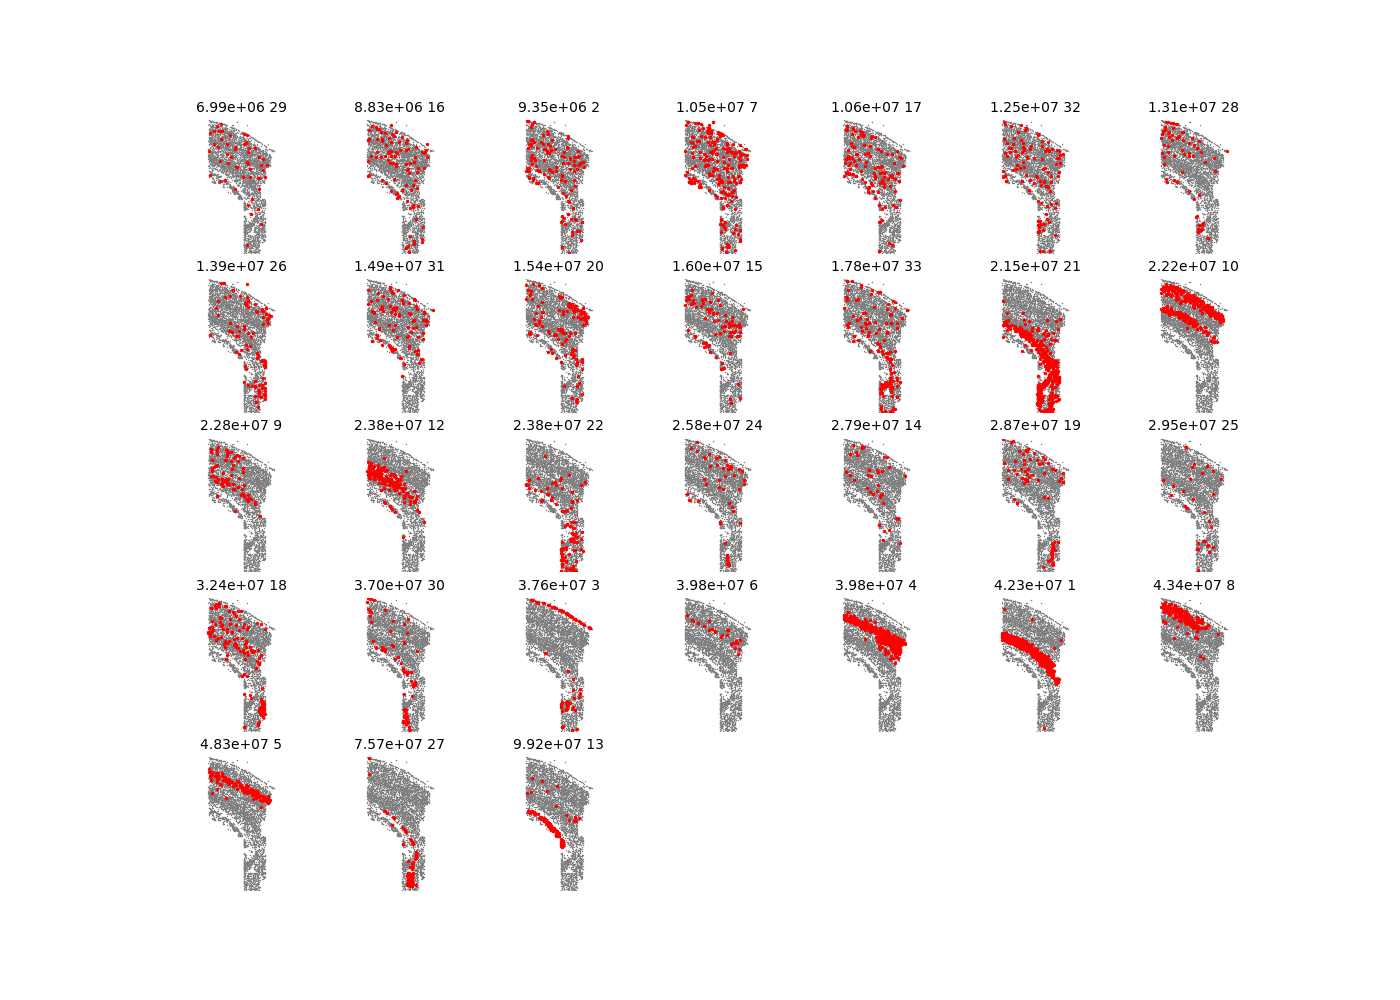

Clusterdness ascending: [29, 16, 2, 7, 17, 32, 28, 26, 31, 20, 15, 33, 21, 10, 9, 12, 22, 24, 14, 19, 25, 18, 30, 3, 6, 4, 1, 8, 5, 27, 13]
6993475.626978085,
8833245.447443381,
9350642.397315973,
10471638.47200238,
10618530.49410992,
12493266.006855536,
13092246.03876766,
13948525.56369805,
14929468.18481575,
15445584.46833338,
15988428.511748752,
17783203.245484006,
21530767.204957772,
22184232.101648536,
22800893.474554837,
23816790.06091608,
23841394.182879835,
25804019.08486673,
27872547.788680777,
28742416.313074768,
29454503.20371401,
32372513.875106703,
37014385.83645177,
37631292.267059304,
39790464.77418566,
39805450.138431594,
42296484.726211265,
43391676.14920194,
48285599.07411661,
75740151.09526458,
99183531.19617982,


In [9]:
plt.figure(figsize=(14,10))
n_clusters = len(np.unique(labels_a))
gs = plt.GridSpec(5, int(n_clusters/5) + (n_clusters % 5 > 0))

RK_dist = RK_750

for i, c in enumerate([np.unique(labels_a)[i] for i in np.argsort(RK_dist)]):
    plt.subplot(gs[i])
    filt = labels_a == c
    plot_cell_pos(df_coord, cell_ids=list(df_fish_totmol_clean.columns[filt]), cell_of_interest=None, s=1, standalone=False, color_highlight1='r')
    plt.gca().set_axis_off()
    plt.title('{} {}'.format("{:.2e}".format(RK_dist[np.argsort(RK_dist)[i]]),c), fontsize=10)
    
print('Clusterdness ascending: {}'.format([np.unique(labels_a)[i] for i in np.argsort(RK_dist)]))
for i in np.sort(RK_dist):
    print('{},'.format(i))
#print('{},'.format(np.sort(RK_dist)))

In [120]:
RK_cutoff = 2e7 #2.2e7
spatial_clusters = [np.unique(labels_a)[n] for n,i in enumerate(RK_750) if i>RK_cutoff]
spatial_clusters

[1, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 18, 19, 21, 22, 24, 25, 27, 30]

In [119]:
manual_spatial_clusters = [13,27,5,10,1,4,3,18,19,21]

In [9]:
combinations_dict = {}
for n, i in enumerate(np.unique(labels_a)):
    combinations_dict[str(i)] = n+1
    
for n, i in enumerate(itertools.combinations(np.unique(labels_a), 2)):
    name = '{}_{}'.format(i[0], i[1])
    combinations_dict[name] = n+len(np.unique(labels_a)) +1 


In [10]:
n = [12,12,12,12,14,15,1,16]
per = [(Counter(n)[i] / len(n)  * 100) for i in Counter(n)]

top_labels = []
for i in np.argsort(per)[:1:-1]:
    if per[i] > 20:
        top_labels.append(list(Counter(n).keys())[i])
        
if len(top_labels) == 1:
    name = str(top_labels[0])
if len(top_labels) == 2:
    name = '{}_{}'.format(sorted(top_labels)[0], sorted(top_labels)[1])
    
name

'12'

In [443]:
def regionalization(cell_coordinates, labels, neighbors, cycles=None, max_dist=np.inf, included_labels=None,
                    percentage_cutoff = 0, reset_label_round=None, reset_count_cutoff=None, 
                    reset_to_9999 = False, merge_labels=False, remove_islands = True, remove_island_round = [],
                    island_max_dist = np.inf, island_minimal_group=100, post_split=False, force_id = False, 
                   force_id_cutoff = 10, giving_back_round=[]):
    """
    Regionalize the sample by converting all cells to the identity of the cell type 
    with the highest regional density, so that some abuntant cell types define the 
    regions of the area. 
    It is an iterative process. In each round for each cell the identity of the
    closest k cells is checked and the cells own label will convert to the most 
    abundant labels among its neigbours.
    Input:
    `cell_coordinates`(pandas df): Data frame with X Y coordinates of every cell.
    `labels`(array): Numpy array with the cell labels in the same order as the cells
        in the cell_coordinates dataframe.
    `neighbors`(list of int OR int): Number of neighbours, or k, used to determine the 
        most abundant label of the cells k neighbours. Can either be a list of values
        with the lengt equal to the number of cycles or a single integer.
    `cycles`(int): Number of iterations to run. The results of each iteration will be
        saved
    `max_dist`(list of float OR float): To restrict the neigbours to only neighbours
        that are within the "max_dist" of the questioned cell. Can either be a single
        distance or a list of distances equal to the number of cycles if you want to
        use different distances per iteration.
    `included_labels`(list of labels): List fo valid labels that the cells can adapt,
        These are pre-defined by selecting labels that demonstrate some regional
        pattern or preference. Ripley's K Estimate might be a helpfull metric.
    `percentage_cutoff`(float 0-100): When converging labels, the new label is only
        accepted if it is the most abundant and is above the percentage cutoff.    
    `reset_label_round`(list of rounds): Rounds in which the algorithm should 
        reset the new identity of a cell to its original one, if a label starts
        dominiating regionally and is present only in small numbers.
    `reset_count_cutoff`(int): Cutoff to decide if the cells having a certain label
        should be recet to their original label. Example; if a label starts to dominate
        locally with only 20 cells and the cutoff is 21, it will reset these cells.
    `reset_to_9999`(bool): Option to reset the cells to the label 9999 and not to 
        their original lable. Advantage: 9999 will not be in the valid labels and
        therefore will not propagate in the same way as the removed label did.
    `merge_labels`(bool): (Experimental function) If multiple labels are present in 
        one area the algorithm can merge them so that also areas of an unique mix
        of labels can be defined. 
    `remove_islands`(bool): Sometimes a labeled region has also some sattelite regions
        of a few cells. These can be removed. A graph is build using the island_max_dist
        to make a connected graph between cells that are within that distance of each
        other and have the same label. If a group of cells is too far it will not 
        connect to the other cells with the same label. 
    `remove_island_round`(list of rounds): Round(s) in which to remove the islands.
    `island_max_dist`(int): Max distance to use when building the connected graph
    `island_minimal_group`(int): Cutoff number of cells that is used to determine if
        an island is valid. If it is too small if will be removed by reseting the
        cell labels to their original value or 9999 depending on the 'reset_to_9999'
    `post_split`(bool): If a label has more than one region and these are not connected
        (using the 'island_max_dist'), they will be split and given new labels.
    `force_id`(bool): Remote cells might not converge to the local label. These cells
        can be forced to adapt the local label by using the 'neigbours' without 
        distance restriction.
    `force_id_cutoff`(int): Cutoff below which the number of cells of one labels is
        not considered valid and should be forced to adapt the local label.
    `giving_back_round`(list of rounds): It is possible that a label starts to 
        expand past its region due to the iterative process. This can be stopped
        by reseting cells that first belonged to a label that is still present in the
        dataset but now converted to another label, to their original label.
    Retruns:
    `label_matrix`(pandas df): Dataframe with the cells in the columns and their 
        labels in the rows. Each round of the iteration has one row with the labels
        so that the process can be investigated. Special operations like 'force_id'
        will get their own row.
    
    """

    #____FUNCTIONS____________________________________________________________
    def reset_labels(label_matrix, count_threshold, reset_to_9999=False):
        """
        Reset the labels of clusters that are present in low numbers to their original labels.
        Input:
        `label_matrix`(pandas dataframe): Dataframe with labels in rows for each iteration 
            and cells in columns
        `count_threshold`(int): Number or cells with a specific label to be resit
        `reset_to_zero`(bool): Does not reset to the original labels but to 9999. 
            9999 should not be included in the included_labels.
        Returns:
        Array of reset labels
        
        """
        label_matrix = label_matrix.T
        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        new_label = 'Reset_labels'
        for i in np.unique(label_matrix.iloc[-1]):
            if list(label_matrix.iloc[-1]).count(i) < count_threshold:
                filt = label_matrix.iloc[-1] == i
                if reset_to_9999 == False:
                    label_matrix.loc[last_label,filt] = label_matrix.loc[first_label,filt]
                else:
                    label_matrix.loc[last_label,filt] = [9999] * label_matrix.loc[last_label].value_counts()[i]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    def giving_back(label_matrix):
        """
        Reset labels of cells to their original label, if the original label 
        is still present in the dataset.
        
        """
        label_matrix = label_matrix.T
        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        valid_labels = np.unique(label_matrix.loc[last_label,:])
        for c in label_matrix.columns:
            if label_matrix.loc[first_label, c] in valid_labels:
                label_matrix.loc[last_label, c] = label_matrix.loc[first_label, c]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    def max_dist_graph(coordinates, max_dist=np.inf):
        """
        Build a graph with the coordinates as nodes and edges if the nodes are 
        within the max_dist from each other
        Input:
        `coordinates`(array): Array with the coordinates from each node.
        `max_dist`(float): Max distance nodes can be spaced from each other to 
            be connected.
        Retruns:
        A networkx graph

        """
        #Transpose coordinate df if X and Y are in the rows
        if coordinates.shape[0] == 2:
            coordinates = coordinates.T

        #Built the KDTree
        nn_tree = scipy.spatial.KDTree(coordinates, leafsize=10)

        #Find the pairs of nodes within the max_dist
        cell_pairs = [[coordinates.index[j] for j in i] for i in nn_tree.query_pairs(max_dist)]

        #Build the graph
        G = nx.Graph()
        G.add_nodes_from(coordinates)
        G.add_edges_from(cell_pairs)

        return G

    def reset_islands(label_matrix, coordinates, max_dist=1000, minimal_group = reset_count_cutoff, reset_to_9999=False):
        """
        Makes a Graph of the cells belonging to a label, and resets the labels of cell groups (or islands)
        that are isolated and below the minimal_group size.
        
        """
        label_matrix = label_matrix.T

        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        for i in np.unique(label_matrix.iloc[-1]):
            filt = label_matrix.iloc[-1] == i
            coi = coordinates.loc[filt]
            G = max_dist_graph(coi, max_dist=max_dist)
            for group in nx.connected_components(G):
                if group == {coordinates.columns[0]} or group == {coordinates.columns[1]}:
                    pass
                else:
                    if len(group) < minimal_group:
                        for item in group:
                            if reset_to_9999 == True:
                                label_matrix.loc[last_label, item] = 9999
                            else:
                                label_matrix.loc[last_label, item] = label_matrix.loc[first_label, item]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    
    label_matrix = pd.DataFrame(data=labels, columns=['Start'], 
                                index=cell_coordinates.columns, dtype='Int64')
    
    #____PREPARATION___________________________________________________________
    #Transpose coordinate df if X and Y are in the rows
    if cell_coordinates.shape[0] == 2:
        cell_coordinates = cell_coordinates.T
        
    #Build the distance tree
    nn_tree = scipy.spatial.KDTree(cell_coordinates, leafsize=10)
    
    #Make lists for neighbors and max dist if an integer is passed
    if type(neighbors) == int:
        neighbors = [neighbors for i in range(cycles)]
    if type(max_dist) == int:
        max_dist = [max_dist for i in range(cycles)]
    if len(neighbors) != cycles:
        print('Number of cycles ({}) does not match the number of "neighbours" ({})'.format(cycles, len(neighbors)))
        return
    if len(max_dist) != cycles:
        print('Number of cycles ({}) does not match the number of "max_dist" ({})'.format(cycles, len(max_dist)))
        return
    
    
    #____OPTIONAL_MERGE_LABELS_________________________________________________
    #Optional make merged labels
    if merge_labels == True:
        #Store names of cluster combinations in one dictionary
        combinations_dict = {}
        for n, i in enumerate(np.unique(labels_a)):
            combinations_dict[str(i)] = n+1
        for n, i in enumerate(itertools.combinations(np.unique(labels_a), 2)):
            name = '{}_{}'.format(i[0], i[1])
            combinations_dict[name] = n+len(np.unique(labels_a)) +1 
        
        for c in label_matrix.index:
            #Ask for the nearest neighbors of a cell
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=neighbors[0],
                                    distance_upper_bound=max_dist[0])[1]
            #if distance_upper_bound is used the query() func will put the max shape
            #in the list to fill for the neigbours out of range
            nearest = [i for i in nearest if i != cell_coordinates.shape[0]] 
            nearest_clusters = label_matrix.iloc[nearest,0]
            nearest_clusters = [i for i in nearest_clusters if i in included_labels]
            if nearest_clusters == []:
                label_matrix.loc[c,'merge_label'] = 0
            else:
                percentage = [(Counter(nearest_clusters)[i] / len(nearest_clusters)  * 100) for i in Counter(nearest_clusters)]

                top_labels = []
                for i in np.argsort(percentage)[:1:-1]:
                    if percentage[i] > percentage_cutoff:
                        top_labels.append(list(Counter(nearest_clusters).keys())[i])

                if len(top_labels) == 1:
                    name = str(top_labels[0])
                if len(top_labels) == 2:
                    name = '{}_{}'.format(sorted(top_labels)[0], sorted(top_labels)[1])
                label_matrix.loc[c,'merge_label'] = combinations_dict[name]
    
    #____CONVERGE_LABELS_______________________________________________________
    for n, k in enumerate(neighbors):
        iteration = 'Iteration_{}'.format(n+1)
        label_matrix.loc[:,iteration] = label_matrix.iloc[:,n]
        if merge_labels == True:
            col = n + 1
        else:
            col = n
            
        for c in label_matrix.index:
            #Ask for the nearest neighbors of a cell
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=k,
                                    distance_upper_bound=max_dist[n])[1]
            #if distance_upper_bound is used the query() func will put the max shape
            #in the list to fill for the neigbours out of range
            nearest = [i for i in nearest if i != cell_coordinates.shape[0]] 
            nearest_clusters = list(label_matrix.iloc[nearest,col])
            if merge_labels == False:
                nearest_clusters = [i for i in nearest_clusters if i in included_labels]
            if nearest_clusters == []:
                pass
            else:
                ct = Counter(nearest_clusters)
                most_common_rank = [(i, ct[i] / len(nearest_clusters) * 100.0) for i, count in ct.most_common()]
                if most_common_rank[0][1] > 30 and  (True if len(ct)==1 else True if most_common_rank[0][1] != most_common_rank[1][1] else False):
                    label_matrix.loc[c,iteration] = most_common_rank[0][0] 
                else:
                    pass
                

        #____RESET_FUNCTIONALITIES_____________________________________________        
        #Reset the labels to the original value or to 9999
        if reset_label_round != None and n+1 in reset_label_round: #reset_label_round == n+1
            print('Resetting labels')
            label_matrix.loc[:,iteration] = reset_labels(label_matrix, reset_count_cutoff, reset_to_9999=reset_to_9999)
            print('Completed resetting of labels')
            
        #Remove Islands and reset labels to the original value or to 9999
        if remove_island_round != None and n+1 in remove_island_round:
            print('Removing islands')
            label_matrix.loc[:,iteration] = reset_islands(label_matrix, cell_coordinates, 
                                                          max_dist=island_max_dist, 
                                                          minimal_group = island_minimal_group,
                                                         reset_to_9999 = reset_to_9999)
            print('Completed removal of islands')
            
        #Give back cells if they changed label but originaly belonged to a sill-present label
        if giving_back_round != None and n+1 in giving_back_round:
            print('Giving back')
            label_matrix.loc[:,iteration] = giving_back(label_matrix)
            print('Completed giving back')
            
        label_matrix = label_matrix.astype('Int64') 
    
    label_matrix = label_matrix.T.astype('Int64')    
    
    #____POST-CONVERSION_OPERATIONS____________________________________________
    #Post split separated areas with the same label
    if post_split == True:
        last_row = label_matrix.index[-1]
        label_matrix.append(label_matrix.loc[last_row])
        label_matrix.index = label_matrix.index.where((label_matrix.index != last_row), 'post_split')
        for i in np.unique(label_matrix.loc['post_split']):
            filt = label_matrix.loc['post_split'] == i
            coi = cell_coordinates.loc[filt]
            G = max_dist_graph(coi, max_dist=island_max_dist)
            cc = list(nx.connected_components(G))[2:]
            #cc = [i for i in cc if i not in ['{{}}'cell_coordinates.index[0], cell_coordinates.index[1]]]
            if len(cc) > 1:
                max_label = np.unique(label_matrix)[-2]
                for n, c in enumerate(cc):
                    label_matrix.loc['post_split', c] = [max_label + n + 1] * len(c)
                    print('Post_split {}, new label: {}'.format(i, (max_label + n + 1)))
        print('Split disconnected areas with same label. Data in "post_split" row')
        

    #Force the identity of labels with few cells
    if force_id == True:
        last_row = label_matrix.index[-1]
        label_matrix.loc['force_id'] = label_matrix.loc[last_row]
        counter = Counter(label_matrix.loc['force_id'])

        counter = dict(Counter(label_matrix.loc[last_row]))
        small_id = [k for k, v in counter.items() if v < force_id_cutoff]
        cells_to_reset = [c for l, c in zip(label_matrix.loc['force_id'], label_matrix.columns) if l in small_id]
        for c in cells_to_reset:
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=int(0.5 * k), distance_upper_bound=np.inf)[1]
            #nearest = [i for i in nearest if i != df_coord.T.shape[0]] 
            nearest_clusters = list(label_matrix.iloc[-2,nearest].astype('Int64'))
            most_common_label = int(np.argmax(np.bincount(nearest_clusters)))
            label_matrix.loc['force_id',c] = most_common_label
        print('''Removed labels with less than {} cells. forced the id of {} cells with labels: {}. 
        Data in "force_id" row'''.format(force_id_cutoff, len(cells_to_reset), small_id))
    
    #____RETURN________________________________________________________________
    return label_matrix

#Good results sofar:
"""label_matrix= regionalization(df_coord, labels_a, 20, cycles=10, included_labels = manual_spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500,600,600,600,600] ,reset_label_round = [5,7], reset_count_cutoff=300,
                             merge_labels=False) #[10,10,10,7,7,7,7] [500,500,500,500,500,500,1000] [5,7]"""

"""label_matrix= regionalization(df_coord, labels_a, 50, cycles=6, included_labels = manual_spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500] ,reset_label_round = [], reset_count_cutoff=300,
                             merge_labels=True) #[10,10,10,7,7,7,7] [500,500,500,500,500,500,1000] [5,7]"""

#Used for figures pre-submission
"""label_matrix= regionalization(df_coord, labels_a, 20, cycles=14, included_labels = spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500,500,600,600,600,1000,1000,1000,1000] ,reset_label_round = [], reset_count_cutoff=300,
                             merge_labels=False, remove_islands = True, remove_island_round = [5,7],
                             island_max_dist = 3000,  island_minimal_group=100, post_split=True,
                             force_id = True, force_id_cutoff = 20) #[5,9] is_min_group = 75"""

#Used for first version of figures with first clustering  
#Added giving back functionality
"""label_matrix= regionalization(df_coord, labels_a, 20, cycles=16, included_labels = spatial_clusters,
                             max_dist=[1000,1000,500,500,500,500,500,600,600,600,1000,1000,1000,1000,1000,1000],
                             reset_label_round = [], reset_count_cutoff=200, reset_to_9999 = True,
                             merge_labels=False, remove_islands = True, remove_island_round = [5,7,14],
                             island_max_dist = 3000,  island_minimal_group=100, post_split=True,
                             force_id = True, force_id_cutoff = 20, giving_back_round=[12])"""


"""label_matrix= regionalization(df_coord, labels_a, 20, cycles=20, included_labels = spatial_clusters,
                             max_dist=[200,200,300,300,1000,400,500,500,600,600,700,700,800,800,900,900,1000,1000],
                             reset_label_round = [], reset_count_cutoff=200, reset_to_9999 = False,
                             merge_labels=False, remove_islands = True, remove_island_round = [5,10,16],
                             island_max_dist = 2000,  island_minimal_group=50, post_split=False,
                             force_id = True, force_id_cutoff = 20, giving_back_round=[14])"""

#Works with clustering 180220
"""label_matrix= regionalization(df_coord, labels_a, 20, cycles=18, included_labels = spatial_clusters,
                             max_dist=[1000,1000,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1500,1500],
                              percentage_cutoff = 50,
                             reset_label_round = [], reset_count_cutoff=200, reset_to_9999 = True,
                             merge_labels=False, remove_islands = True, remove_island_round = [5,7,10,16],
                             island_max_dist = 3000,  island_minimal_group=75, post_split=True,
                             force_id = True, force_id_cutoff = 20, giving_back_round=[14])"""

label_matrix= regionalization(df_coord, labels_a, 20, cycles=18, included_labels = spatial_clusters,
                             max_dist=[1000,1000,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1500,1500],
                              percentage_cutoff = 50,
                             reset_label_round = [], reset_count_cutoff=200, reset_to_9999 = True,
                             merge_labels=False, remove_islands = True, remove_island_round = [5,7,10,16],
                             island_max_dist = 3000,  island_minimal_group=75, post_split=True,
                             force_id = True, force_id_cutoff = 20, giving_back_round=[14])

copy = label_matrix.copy()


Removing islands
Completed removal of islands
Removing islands
Completed removal of islands
Removing islands
Completed removal of islands
Giving back
Completed giving back
Removing islands
Completed removal of islands
Post_split 10, new label: 34
Post_split 10, new label: 35
Post_split 9999, new label: 36
Post_split 9999, new label: 37
Split disconnected areas with same label. Data in "post_split" row
Removed labels with less than 20 cells. forced the id of 5 cells with labels: [37, 36, 9999]. 
        Data in "force_id" row


force_id


<IPython.core.display.Javascript object>


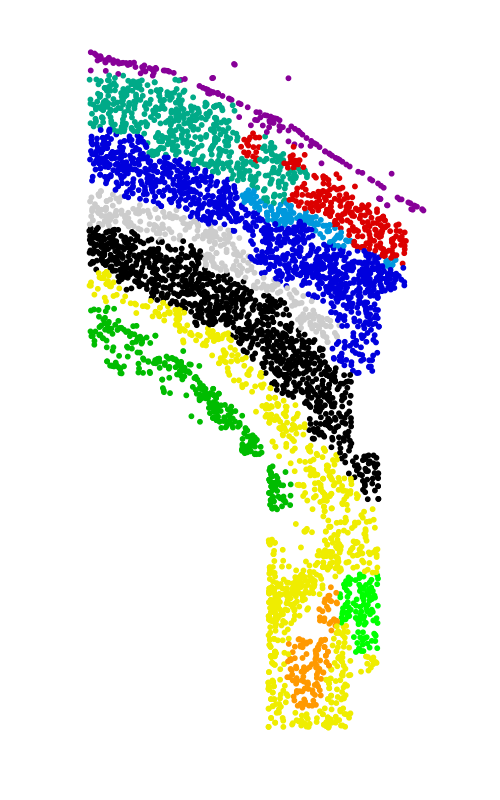

Number of labels: 11
Counter({1: 1015, 4: 1002, 21: 877, 8: 549, 13: 322, 35: 295, 34: 254, 3: 159, 5: 131, 27: 129, 18: 106})


/home/lars/programs/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [444]:
plot_regions(df_coord, label_matrix, 19, predefined_labels=False) 

force_id


<IPython.core.display.Javascript object>


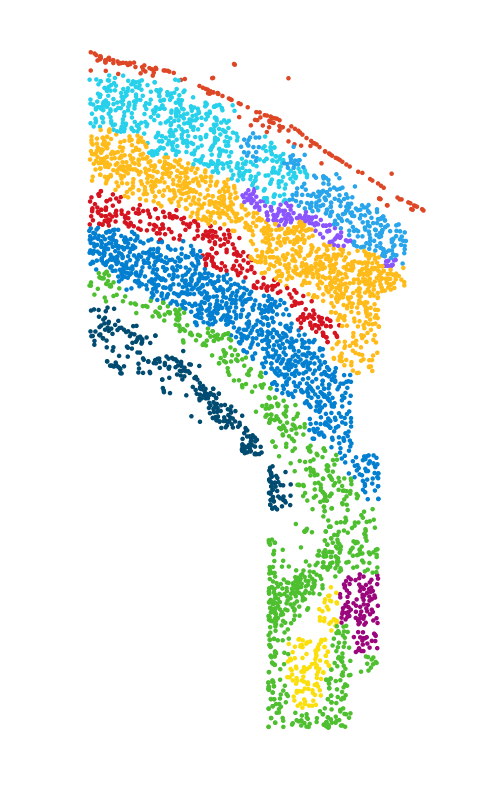

Number of labels: 11
Counter({1: 1015, 4: 1002, 21: 877, 8: 549, 13: 322, 35: 295, 34: 254, 3: 159, 5: 131, 27: 129, 18: 106})


In [452]:
region_colors = {
    63: '#ff4200',
    54: '#008aea',
    96: '#00bcea',
    90: '#4400AA',
    95: '#AA0044',
    91: '#0055D4',
    94: '#00D400',
    27: '#ffc52a',
    68: '#D35FBC',
    79: '#161650'
    }
region_colors = {
    1:'#027fd0',
    3:'#de4726',
    4:'#ffbb19',#3ba593
    5:'#8a55ff',
    8:'#28d1eb',
    13:'#004b71',
    18:'#9b067d',
    21:'#4ec030',
    27:'#fadf0c',
    34:'#28a5eb',
    35:'#d61420',
    }

def plot_regions(cell_coordinates, label_matrix, level, predefined_labels= True):
    print(label_matrix.index[level])
    fig, ax = plt.subplots(figsize=(5,8))
    
    if predefined_labels == False:
        c_labels = [list(np.unique(label_matrix.iloc[level])).index(i) for i in label_matrix.iloc[level]]
    else:
        c_labels = [region_colors[i] for i in label_matrix.iloc[level]]
    
    ax.scatter(cell_coordinates.loc['X'], cell_coordinates.loc['Y'], s=5,
              c = c_labels, 
              cmap = 'spectral') 
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_axis_off()
    print('Number of labels: {}'.format(len(np.unique(label_matrix.iloc[level]))))
    print(Counter(label_matrix.iloc[level]))
    plt.tight_layout()
    
plot_regions(df_coord, label_matrix, 19, predefined_labels=True) 
plt.savefig('regionalization_180220.pdf')

#Save labels of cells
cell_labels_regions = dict(zip(label_matrix.columns, label_matrix.iloc[-1]))
pickle.dump(cell_labels_regions, open('cell_label_region_180220.p', 'wb'))

#Save cells in regions
region_cells = {}
for l in np.unique(list(cell_labels_regions.values())):
    region_cells[l] = []
for k,v in cell_labels_regions.items():
    region_cells[v].append(k)
pickle.dump(region_cells, open('region_cells_180220.p', 'wb'))

pickle.dump(region_colors, open( "region_colors_180220.p", "wb" ))

In [65]:
label_matrix.index

Index(['Start', 'Iteration_1', 'Iteration_2', 'Iteration_3', 'Iteration_4',
       'Iteration_5', 'Iteration_6', 'Iteration_7', 'Iteration_8',
       'Iteration_9', 'Iteration_10', 'Iteration_11', 'Iteration_12',
       'Iteration_13', 'Iteration_14', 'Iteration_15', 'post_split',
       'force_id'],
      dtype='object')

<IPython.core.display.Javascript object>


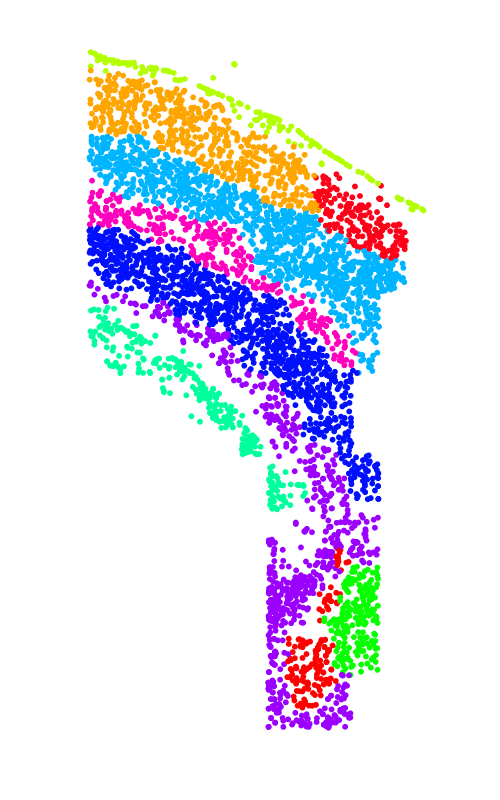

Number of labels: 10
Counter({90: 1068, 91: 1016, 94: 749, 54: 577, 95: 311, 79: 307, 68: 189, 96: 188, 63: 150, 27: 145})


In [82]:
plot_regions(df_coord, label_matrix,17 , predefined_labels=False)

<IPython.core.display.Javascript object>


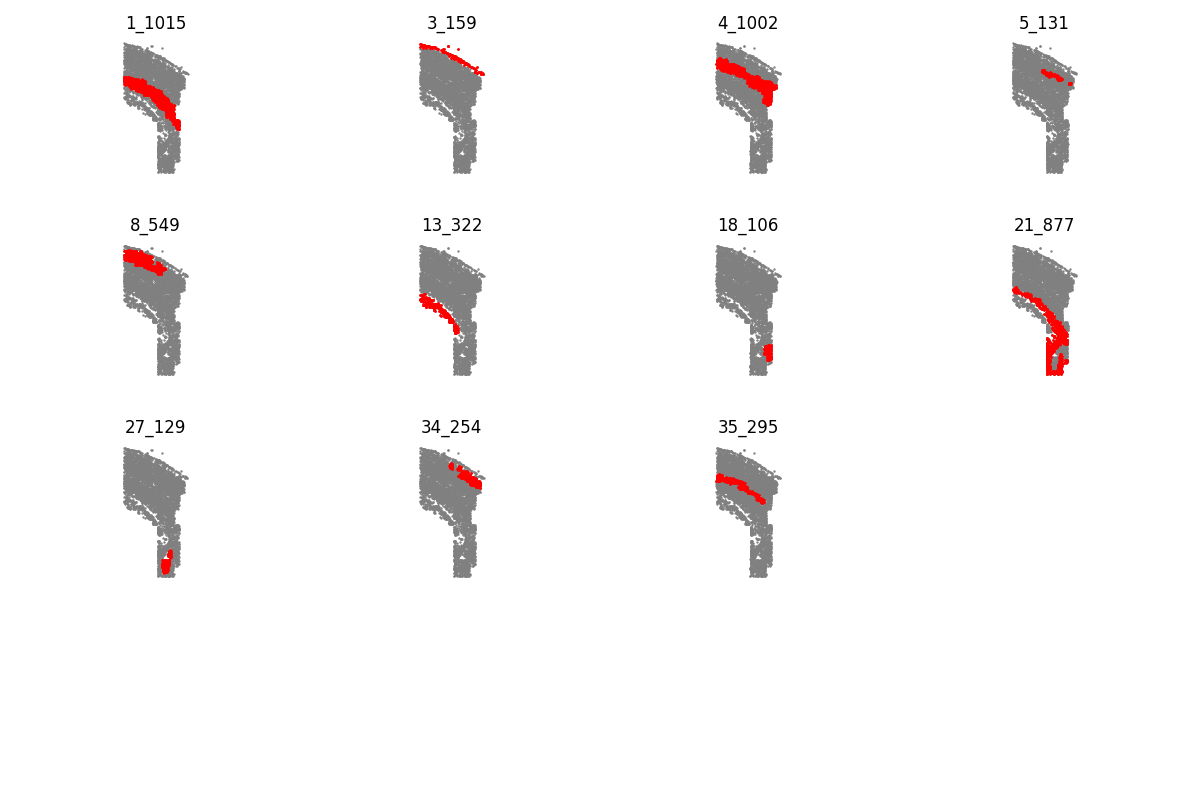

In [446]:
def plot_region_label(cell_coordinates, label_matrix, level):
    fig = plt.figure(figsize=(12,8))
    gs = plt.GridSpec(4,4)
    
    for n,i in enumerate(np.unique(label_matrix.iloc[level])):
        plt.subplot(gs[n])
        ax=plt.gca()
        filt = label_matrix.iloc[level] == i

        ax.scatter(cell_coordinates.loc['X'], cell_coordinates.loc['Y'], s=.5,c = 'grey')
        ax.scatter(cell_coordinates.loc['X', filt], cell_coordinates.loc['Y',filt], s=1,c = 'red')   
        
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.invert_xaxis()
        ax.set_axis_off()
        ax.set_title('{}_{}'.format(i, Counter(filt)[1]))
    plt.tight_layout()

plot_region_label(df_coord, label_matrix, 19) 

#plt.savefig('Regionalization_individual_areas_v2.png', dpi=300)

# Cell type content

In [180]:
cluster_names = {
13: 'Pyramidal L4 2',
17: 'Oligodendrocyte COP',
21: 'Pyramidal interface L3-4',
27: 'Ependymal',
37: 'Pericytes',
41: 'Oligodendrocytes MF',
43: 'OPC',
45: 'Py Cpne5',
47: 'Inhibitoryn Pthlh',
54: 'Pyramidal L2-3',
55: 'Pyramidal L2-3 L5',
61: 'Oligodendrocyte NF',
62: 'Astrocyte Mfge8',
63: 'Astrocyte Gfap',
66: 'Inhibitory Kcnip2',
68: 'Inhibitory  Syt6',
69: 'Inhibitory Slc32a1-',
73: 'Inhibitory Crh',
75: 'Microglia',
78: 'Inhibitory Cnr1',
79: 'Hippocampal neuron',
81: 'Choroid plexus',
83: 'PVM VSM',
85: 'Inhibitory Vip',
86: 'Inhibitory Lamp5',
87: 'Pyramidal L5',
88: 'BQ',
89: 'Endothelial 1',
90: 'Pyramidal L4',
91: 'Pyramidal L6',
92: 'Endothelial',
93: 'Inhibitory Crhbp',
94: 'Oligodendrocyte mature'}

cluster_colors = {
    13: '#4facdc',
    17: '#5bc241',
    21: '#31609d',
    27: '#ffdf05',
    37: '#ccec19',
    41: '#508966',
    43: '#64c099',
    45: '#0e5d77',
    47: '#d5416a',
    54: '#62a8ba',
    55: '#396e87',
    61: '#66a44f',
    62: '#f69048',
    63: '#dc4501',
    66: '#983fd8',
    68: '#d0839e',
    69: '#592d95',
    73: '#a7506a',
    75: '#a7623c', #00c690
    78: '#a16cda',
    79: '#06405e',
    81: '#026449',
    83: '#772b0d', #bc23b3
    85: '#68396c',
    86: '#cf47ac',
    87: '#80a5da',
    88: '#6b6b6b',
    89: '#ef5454',
    90: '#41c6dd',
    91: '#538ee1',
    92: '#fb2828',
    93: '#bc89ca',
    94: '#2c5525'
}

region_anatomical_names = {27 : 'Ventricle',
                           54 : 'Layer 2-3 medial',
                           63 : 'Pia Layer 1',
                           68 : 'Internal Capsula Caudo Putamen',
                           79 : 'Hippocampus',
                           90 : 'Layer 4',
                           91 : 'Layer 6',
                           94 : 'White matter',
                           95 : 'Layer 5',
                           96 : 'Layer 2-3 lateral'}

clusters_sorted = [68,69,66,93,78,85,47,73,
              54,21,45,55,90,13,87,91,79,
              63,62,43,17,61,41,94,83,75,81,27,37,92,89]

In [70]:
region_cells.keys()

dict_keys([27, 54, 63, 68, 79, 90, 91, 94, 95, 96])

<IPython.core.display.Javascript object>


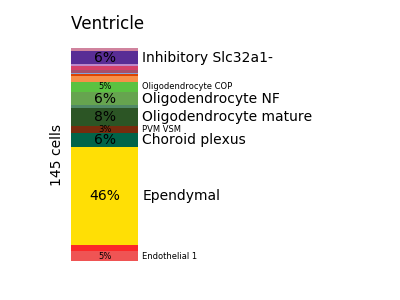

<IPython.core.display.Javascript object>


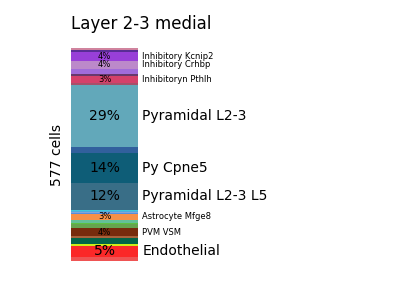

<IPython.core.display.Javascript object>


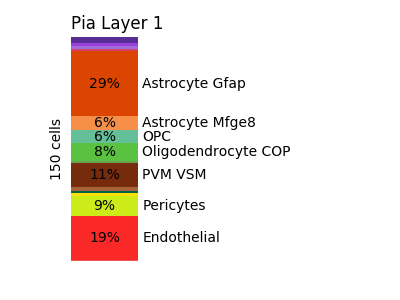

<IPython.core.display.Javascript object>


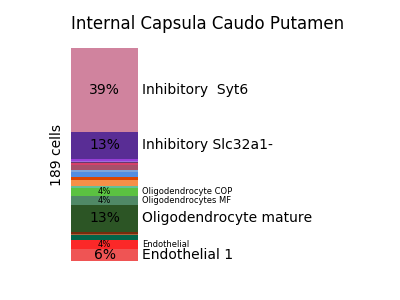

<IPython.core.display.Javascript object>


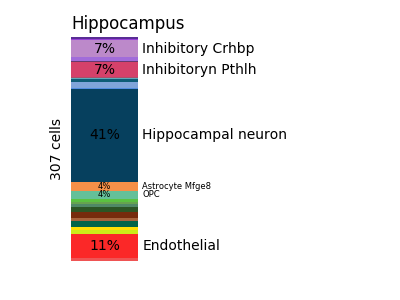

<IPython.core.display.Javascript object>


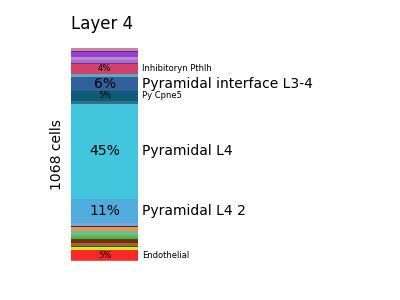

<IPython.core.display.Javascript object>


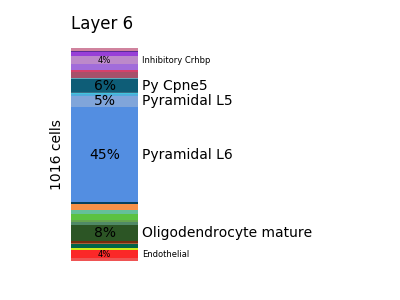

<IPython.core.display.Javascript object>


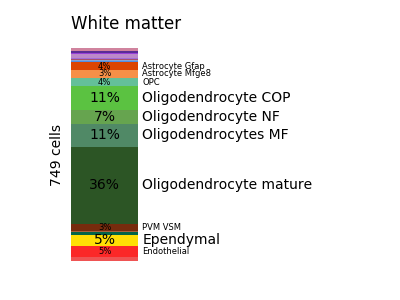

<IPython.core.display.Javascript object>


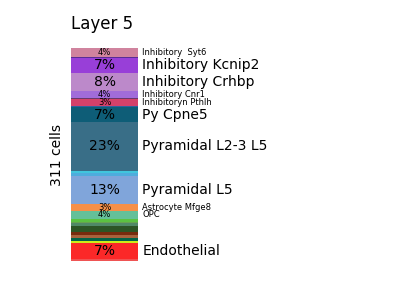

<IPython.core.display.Javascript object>


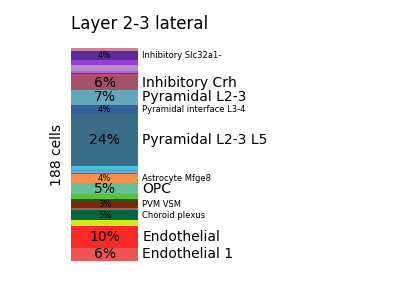

In [181]:

for n, reg in enumerate(np.unique(label_matrix.iloc[17,:])):
    plt.figure(figsize=(4,3))
    cell_content = [cell_labels[i] for i in region_cells[reg]]
    cell_count = Counter(cell_content)
    
    #convert to percentage
    for k in cell_count:
        cell_count[k] = (cell_count[k] / len(cell_content)) * 100
    
    #Sort the dictionary
    #type_sort = sorted(cell_count, key=lambda k: cell_count[k], reverse=True)
    type_sort = clusters_sorted[::-1]
    
    #plot the region contents
    start=0
    for i in type_sort:
        plt.bar(0, cell_count[i], 0.5, bottom=start, color=cluster_colors[i])
        
        if cell_count[i] > 5:
            text_pos = (start + (0.5*cell_count[i]))#-3
            plt.text(0.28, text_pos, cluster_names[i], fontsize=10, va='center')
            plt.text(0, text_pos, '{}%'.format(round(cell_count[i])), fontsize=10, ha='center', va='center')
            
        if 5 > cell_count[i] > 3:
            text_pos = (start + (0.5*cell_count[i]))
            plt.text(0.28, text_pos, cluster_names[i], fontsize=6, va='center')
            plt.text(0, text_pos, '{}%'.format(round(cell_count[i])), fontsize=6, ha='center', va='center')
        start += cell_count[i]
            
    plt.title(region_anatomical_names[reg], loc='left')  
    plt.text(-0.35, 50, '{} cells'.format(len(cell_content)), rotation='vertical', va='center', ha='center')
    plt.ylabel('ahaha')
    plt.xlim((-0.25,2))
    plt.gca().set_axis_off()
    plt.tight_layout()
    
    plt.savefig('tissue_region_content/Stacked_bar/order_{}.png'.format(region_anatomical_names[reg]), dpi=300)

In [153]:
round(4.6, 1)

4.6

In [60]:
type_sort

[91,
 94,
 45,
 87,
 92,
 93,
 17,
 73,
 62,
 78,
 81,
 43,
 66,
 89,
 68,
 61,
 41,
 47,
 83,
 13,
 75,
 37,
 90,
 69,
 55,
 79,
 54,
 85,
 21,
 63]

In [32]:
for k in cell_count:
    cell_count[k] = (cell_count[k] / len(cell_content)) * 100


In [39]:
sum(cell_count.values())

100.00000000000003

In [53]:
count_dict

{13: 7,
 17: 29,
 21: 2,
 37: 7,
 41: 12,
 43: 19,
 45: 60,
 47: 11,
 54: 3,
 55: 5,
 61: 12,
 62: 28,
 63: 1,
 66: 19,
 68: 15,
 69: 5,
 73: 28,
 75: 7,
 78: 27,
 79: 5,
 81: 20,
 83: 8,
 85: 2,
 87: 55,
 89: 15,
 90: 6,
 91: 454,
 92: 39,
 93: 37,
 94: 78}

In [52]:
count_dict = dict(cell_count)
sorted(count_dict, key=lambda k: count_dict[k])

[63,
 85,
 21,
 54,
 69,
 55,
 79,
 90,
 13,
 75,
 37,
 83,
 47,
 61,
 41,
 89,
 68,
 43,
 66,
 81,
 78,
 73,
 62,
 17,
 93,
 92,
 87,
 45,
 94,
 91]